In [1]:
import numpy as np 
import pandas as pd 

from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

from sklearn.model_selection import train_test_split

# kaggle 
# df = pd.read_csv('../input/data-louna-test-nb/train.csv')
# df_test = pd.read_csv('../input/data-louna-test-nb/test.csv')
# stats = pd.read_csv('../input/data-louna-test-nb/players_feats.csv')

# local
df = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
stats = pd.read_csv('data/players_feats.csv')

target = 'who_win'

In [2]:
class Validation :
    def __init__(self, df, target='who_win'):
        self._df = df
        self._target = target

    def validate(self, model, train_fields, cat_fields = [], text_fields = [], test_size = 0.2, importances=True):
        self._train, self._test = train_test_split(
            self._df, 
            test_size = test_size, 
            random_state = 77, 
        )
        return self.fit_model(model, train_fields, cat_fields, text_fields, importances)
    
    def fit_model(self, model, train_fields, cat_fields, text_fields, importances):
        model.fit(
            self._train[train_fields], 
            self._train[self._target], 
            cat_features = cat_fields, 
            text_features = text_fields, 
            verbose = False
        )
        self._model = model
        self.get_score(model, self._test, train_fields, importances, self._target) 
        
    @staticmethod
    def get_score(model, df_to_score, predict_fields, importances=False, target_name='who_win', get_proba=False):
        proba = model.predict_proba(df_to_score[predict_fields])
        Validation.print_metrics(df_to_score[target_name], proba)
        
        if importances: Validation.show_features_importances(predict_fields, model)
        if get_proba: return proba
    
    @staticmethod
    def show_features_importances(fields, model):
        plt.figure(figsize=(8,len(fields)//3))
        plt.barh(fields, model.feature_importances_)
        
    @staticmethod
    def print_metrics(real, proba, proba_2d=True) :
        """
        Класс подсчета и визуализации метрик на валидации
        """
        if proba_2d:
            proba = proba[:,1]

        real = real.astype(int)
        print("AP = ", average_precision_score(real, proba))
        print("roc-auc = ", roc_auc_score(real, proba))
        print("gini = ", 2 * roc_auc_score(real, proba) - 1)
        print("precision = ", precision_score(real, proba.round()))
        print("recall = ", recall_score(real, proba.round()))
        print("f1 = ", f1_score(real, proba.round()))
        
        precision, recall, _ = precision_recall_curve(real, proba)
        disp = PrecisionRecallDisplay(precision=precision, recall=recall)
        disp.plot()
        
        fpr, tpr, _ = roc_curve(real, proba)
        roc_auc = auc(fpr, tpr)
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
        display.plot()
        
        plt.show()     


__Описание__: \
Датасет состоит из аггрегированных за полгода данных по сыгранным матчам (каждый двумя командами). \
Информация по каждому из ~700 наборов (карта+ком1+ком2) занесена в таблицу features двумя строками - \
по одной строке фичей для каждой из участвовавших команд. \
В каждой строке содержится инфа по всем игрокам команды, для каждого: \
__PS__ `на фикс карте против фикс соперников и суммарное/среднее за полгода`
- p1_id - идентификатор 1го игрока команды
- p1_total_kills - кол-во килов
- p1_headshots - кол-во хэдшотов
- p1_total_deaths - кол-во смертей
- p1_kd_ratio - отношение килы/смерти
- p1_damage_per_round - урон за раунд
- p1_grenade_damage_per_round - урон гранатами за раунд
- p1_maps_played - кол-во сыгранных матчей (данным игроком игроком против фикс соперников и на фикс карте?)
- p1_rounds_played - кол-во сыгранных раундов
- p1_kills_per_round - килов за раунд
- p1_assists_per_round - асистов за раунд
- p1_deaths_per_round - смертей за раунд
- p1_saved_by_teammate_per_round - спасен тиммейтом за раунд
- p1_saved_teammates_per_round - спасенных тиммейтов за раунд
- p1_rating - HLTV рейтинг?
- p1_kill_death - опять КД?
- p1_kill_round - хз
- p1_rounds_with_kills - раундов с убийствами
- p1_kill_death_difference - разница килы и смерти
- p1_total_opening_kills - кол-во опен фрагов
- p1_total_opening_deaths - кол-во опен смертей
- p1_opening_kill_ratio - опен КД
- p1_opening_kill_rating - какой то опен рейтинг? насколько хорош ты как опен игрок?
- p1_team_win_percent_after_first_kill - кол-во взятых раундов командой после опен фрага
- p1_first_kill_in_won_rounds - кол-во опен фрагов во взятых раундов



- map_id - идентификатор матча, поэтому в фичах на каждый матч ровно 2 строки со статистиками на каждую команду

In [3]:
i_player_features = [
    'p{}_id',
    'p{}_total_kills',
    'p{}_headshots',
    'p{}_total_deaths',
    'p{}_kd_ratio',
    'p{}_damage_per_round',
    'p{}_grenade_damage_per_round',
    'p{}_maps_played',
    'p{}_rounds_played',
    'p{}_kills_per_round',
    'p{}_assists_per_round',
    'p{}_deaths_per_round',
    'p{}_saved_by_teammate_per_round',
    'p{}_saved_teammates_per_round',
    'p{}_rating',
    'p{}_kill_death',
    'p{}_kill_round',
    'p{}_rounds_with_kills',
    'p{}_kill_death_difference',
    'p{}_total_opening_kills',
    'p{}_total_opening_deaths',
    'p{}_opening_kill_ratio',
    'p{}_opening_kill_rating',
    'p{}_team_win_percent_after_first_kill',
    'p{}_first_kill_in_won_rounds'
]

match_features = [feat.format(player)+f'_{team}' for team in range(1,3) for feat in i_player_features for player in range(1,6)]
match_features_cat = [i_player_features[0].format(player)+f'_{team}' for team in range(1,3) for player in range(1,6)]

In [4]:
merged = df \
    .merge(stats, left_on=['map_id', 'team1_id'], right_on=['map_id', 'team_id'], suffixes=('_main', '')) \
    .merge(stats, left_on=['map_id', 'team2_id'], right_on=['map_id', 'team_id'], suffixes=('_1', '_2'))

In [5]:
merged.head(3)

,map_id,team1_id,team2_id,map_name_main,who_win,p1_id_1,p1_total_kills_1,p1_headshots_1,p1_total_deaths_1,p1_kd_ratio_1,...,p5_rounds_with_kills_2,p5_kill_death_difference_2,p5_total_opening_kills_2,p5_total_opening_deaths_2,p5_opening_kill_ratio_2,p5_opening_kill_rating_2,p5_team_win_percent_after_first_kill_2,p5_first_kill_in_won_rounds_2,team_id_2,map_name_2
0,289,6665,7718,Ancient,0,4954,258,36.0,293,0.88,...,75,-34,21,20,1.05,1.06,76.2,19.0,7718,Ancient
1,715,4411,10577,Inferno,0,8611,178,39.3,208,0.86,...,197,90,64,25,2.56,1.39,75.0,23.3,10577,Inferno
2,157,11251,9455,Nuke,1,7938,494,52.8,397,1.24,...,101,-32,32,35,0.91,1.09,53.1,15.5,9455,Nuke


# catboost baseline

AP =  0.6478910119767743
roc-auc =  0.6096025186934279
gini =  0.2192050373868557
precision =  0.6590909090909091
recall =  0.37662337662337664
f1 =  0.4793388429752067


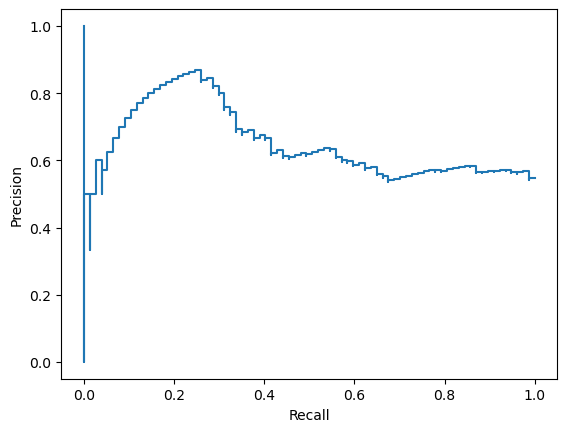

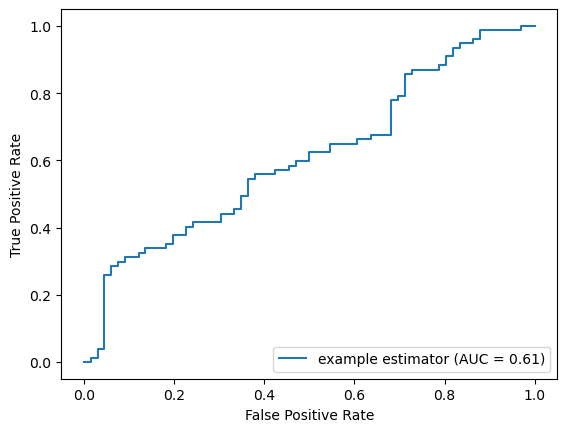

CPU times: user 34 s, sys: 50.3 s, total: 1min 24s
Wall time: 15.4 s


In [6]:
%%time
model = CatBoostClassifier()
val = Validation(merged)
val.validate(model, match_features, match_features_cat, test_size=0.2, importances=False)

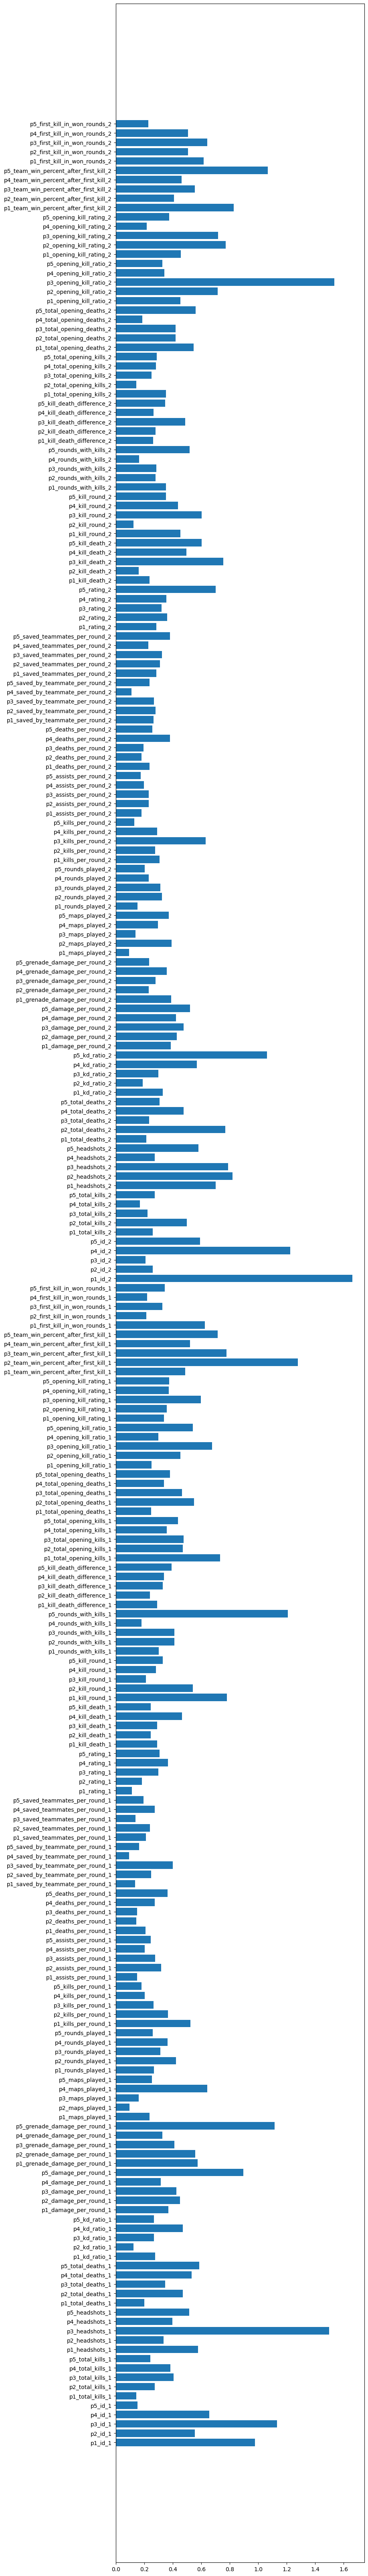

In [7]:
Validation.show_features_importances(match_features, model)

# Что дальше?  

__Очень маленькая выборка и слишком много фичей для нее__ \
Сделаем средние командные фичи и будем использовать лин модель, тк деревья не сумеют хорошо обучиться на таком маленьком датасете

In [8]:
team_avg_features = []

def fill_team_avg_features(df, expand_match_features=True):
    for team in range(1,3):
        team_postfix = f'_{team}'
        for feature in i_player_features[1:]:       
            feature_name = 'team_avg_'+feature[4:]+team_postfix
            df[feature_name] = df[
                # берем столбцы фичи для всех игроков команды
                [feature.format(i)+team_postfix for i in range(1,6)] 
            ].sum(axis=1)/5
            
            if expand_match_features: team_avg_features.append(feature_name)

In [9]:
fill_team_avg_features(merged)

In [12]:
from sklearn.model_selection import cross_validate

lg = LogisticRegression(max_iter=10000, penalty='l2', C=0.01)
res = cross_validate(
    lg,
    merged[team_avg_features],
    merged[target],
    scoring='roc_auc',
    cv=10
)
print(res['test_score'].mean())

0.6453786345233714


# Разметка теста

In [13]:
merged_test = df_test \
    .merge(stats, left_on=['map_id', 'team1_id'], right_on=['map_id', 'team_id'], suffixes=('_main', '')) \
    .merge(stats, left_on=['map_id', 'team2_id'], right_on=['map_id', 'team_id'], suffixes=('_1', '_2'))

fill_team_avg_features(merged_test)

lg_final = LogisticRegression(max_iter=10000, penalty='l2', C=0.01)
lg_final.fit(merged[team_avg_features], merged[target])
test_predict = lg_final.predict(merged_test[team_avg_features])

In [14]:
test_predict

array([0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1])